In [10]:
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model('models/weights.41-0.71.h5')

In [3]:
batch_size = 32
img_height = 512
img_width = 200

In [4]:
dict_classes = {'Alvim': 0,
                'Drive': 1,
                'Helix': 2}

In [5]:
filepath = 'datasets/test/'
classes = sorted(os.listdir(filepath))
classes
x_test = []
y_test = []
for classe in classes:
    imagens = glob.glob(filepath + classe + '/*.jpg')
    for imagem in imagens:
        img = cv2.imread(imagem)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_AREA)
        x_test.append(img)
        y_test.append(dict_classes[classe])

In [6]:
filepath = 'datasets/train/'
classes = sorted(os.listdir(filepath))
classes
x_train = []
y_train = []
for classe in classes:
    imagens = glob.glob(filepath + classe + '/*.jpg')
    for imagem in imagens:
        img = cv2.imread(imagem)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_AREA)
        x_train.append(img)
        y_train.append(dict_classes[classe])

In [8]:
y_train, y_test = np.array(y_train), np.array(y_test)
x_train, x_test = np.array(x_train, dtype = 'float32'), np.array(x_test, dtype = 'float32')

y_train = tf.keras.utils.to_categorical(y_train, num_classes = 3, dtype ="int32")
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 3, dtype ="int32")

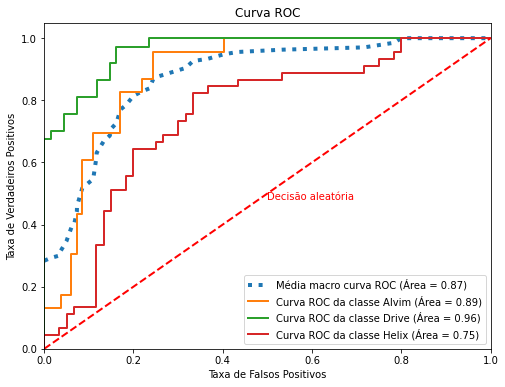

In [14]:
predicted_classes_proba = model.predict(x_test)
classes = list(dict_classes.keys())
tfp, tvp, roc_auc = {}, {}, {}
n_classes=3
for i in range(len(classes)):
    tfp[i], tvp[i], _ = roc_curve(np.array(y_test)[:,i], np.array(predicted_classes_proba)[:,i]) # tfp = taxa de falso positivo/ tvp = taxa de verdadeiro positivo
    roc_auc[i] = auc(tfp[i], tvp[i])

tfp_todas_classes = np.unique(np.concatenate([tfp[i] for i in range(len(classes))]))

media_tvp = np.zeros_like(tfp_todas_classes)
for i in range(n_classes):
    media_tvp += np.interp(tfp_todas_classes, tfp[i], tvp[i])
media_tvp /= n_classes

tfp['macro'] = tfp_todas_classes
tvp['macro'] = media_tvp
roc_auc['macro'] = auc(tfp['macro'], tvp['macro'])

plt.figure(figsize=(8,6))
plt.plot(tfp['macro'], tvp['macro'],
        label='Média macro curva ROC (Área = {0:0.2f})'
            ''.format(roc_auc['macro']), linestyle=':', linewidth=4)

for i,classe in zip(range(len(classes)),classes):
    plt.plot(tfp[i], tvp[i], lw=2,
             label='Curva ROC da classe {0} (Área = {1:0.2f})'
            ''.format(classe, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Decisão aleatória',(.5,.48),color='red')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.savefig('auc_roc.png')
plt.show()